In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from spacy.lang.en.examples import sentences 
import spacy as sp
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet 
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import text

%matplotlib inline

# import zipfile


# import seaborn as sns
# sns.set()

# #Make sure to pip install monkeylearn first
# from monkeylearn import MonkeyLearn
from textblob import TextBlob
import re

In [4]:
tweets = pd.read_csv('data/TrumpTweetsCleaned.csv')
#09-11-2017 to 02-16-2018
before = pd.to_datetime('2017-09-11')
after = pd.to_datetime('2018-02-16')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
# new_tweets = tweets[(tweets['created_at']>=before) and (tweets['created_at']<=after)]
tweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet
0,Look at the way Crooked Hillary is handling th...,2016-11-01 10:31:00,21459.0,55584.0,False
1,Wow now leading in @ABC /@washingtonpost Poll ...,2016-11-01 11:55:00,16479.0,39631.0,False
2,Crooked Hillary should not be allowed to run f...,2016-11-01 12:01:00,23747.0,59656.0,False
3,JOIN ME TOMORROW IN FLORIDA!MIAMI‚Ä¢12pmhttps:...,2016-11-01 13:35:00,8773.0,17583.0,False
4,So terrible that Crooked didn't report she got...,2016-11-01 14:14:00,32713.0,80724.0,False


In [37]:
tweets['polarity'] = [TextBlob(tweets['text'].values[i]).polarity for i in range(len(tweets))]
tweets['subjectivity'] = [TextBlob(tweets['text'].values[i]).subjectivity for i in range(len(tweets))]
tweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet,polarity,subjectivity
0,Look at the way Crooked Hillary is handling th...,2016-11-01 10:31:00,21459.0,55584.0,False,-0.2625,0.422917
1,Wow now leading in @ABC /@washingtonpost Poll ...,2016-11-01 11:55:00,16479.0,39631.0,False,0.2000,0.533333
2,Crooked Hillary should not be allowed to run f...,2016-11-01 12:01:00,23747.0,59656.0,False,0.0000,0.100000
3,JOIN ME TOMORROW IN FLORIDA!MIAMI‚Ä¢12pmhttps:...,2016-11-01 13:35:00,8773.0,17583.0,False,0.0000,0.000000
4,So terrible that Crooked didn't report she got...,2016-11-01 14:14:00,32713.0,80724.0,False,-0.5000,0.550000


In [38]:
len(tweets[tweets['polarity']==0])/len(tweets)

0.19706092458414123

In [39]:
processed_features = []

for sentence in range(0, len(tweets['text'].values)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(tweets['text'].values[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [40]:
tweets['test'] = [TextBlob(processed_features[i]).polarity for i in range(len(processed_features))]
len(tweets[tweets['test']==0])/len(tweets)

0.19491784876007756

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


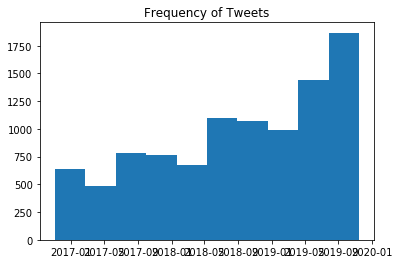

In [41]:
temp = plt.hist(tweets['created_at'])
plt.title('Frequency of Tweets')
plt.show()

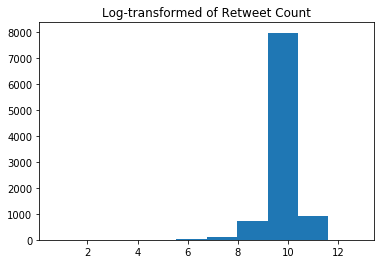

In [42]:
temp2 = plt.hist(np.log(tweets['retweet_count']))
plt.title('Log-transformed of Retweet Count')
plt.show()

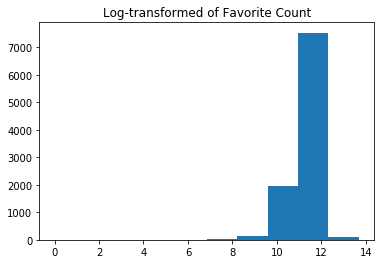

In [44]:
temp3 = plt.hist(np.log(tweets['favorite_count'] + 1))
plt.title('Log-transformed of Favorite Count')
plt.show()

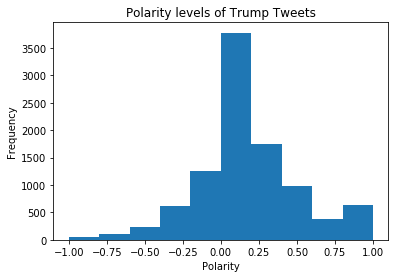

In [43]:
plt.hist(tweets['polarity'])
plt.title('Polarity levels of Trump Tweets')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

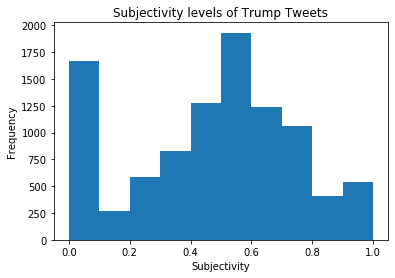

In [45]:
plt.hist(tweets['subjectivity'])
plt.title('Subjectivity levels of Trump Tweets')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

In [12]:
# tweets[(tweets['polarity']==0) & (tweets['subjectivity'] == 0)]

In [46]:
succ = []
for i in range(len(tweets)):
    phrase = tweets['text'].values[i].lower()
    word = 'china'
    if word in phrase:
        succ.append(1)
    else:
        succ.append(0)
tweets['china'] = succ
#tweets[tweets['china']==1]

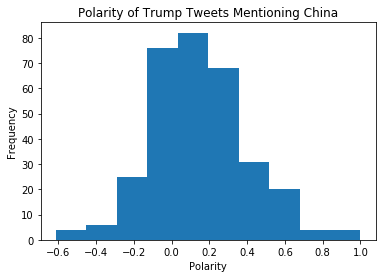

In [47]:
plt.hist(tweets[tweets['china']==1]['polarity'])
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Polarity of Trump Tweets Mentioning China')
plt.show()

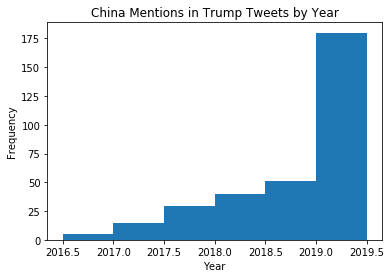

In [48]:
bins = [2016.5, 2017, 2017.5, 2018, 2018.5, 2019, 2019.5]
plt.hist(np.add([r.year for r in tweets[tweets['china']==1]['created_at']], [0.5 if r.week > 26 else 0 for r in tweets[tweets['china']==1]['created_at']]),bins=bins)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('China Mentions in Trump Tweets by Year')
plt.show()

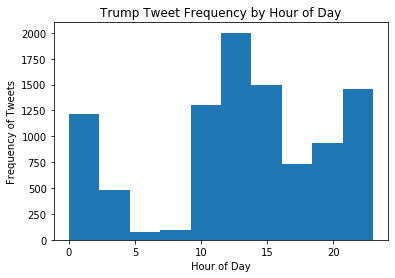

In [49]:
plt.hist([r.hour for r in tweets.created_at])
plt.xlabel('Hour of Day')
plt.ylabel('Frequency of Tweets')
plt.title('Trump Tweet Frequency by Hour of Day')
plt.show()

## Stock Data 

In [50]:
stock = pd.read_csv('data/SP500_intraday.csv')

In [51]:
tweet_dates = tweets['created_at']
tweet_dates.head()

0   2016-11-01 10:31:00
1   2016-11-01 11:55:00
2   2016-11-01 12:01:00
3   2016-11-01 13:35:00
4   2016-11-01 14:14:00
Name: created_at, dtype: datetime64[ns]

In [53]:
stock['Time_pd'] = pd.to_timedelta(stock['Time']+':00')
stock['Date_time'] = pd.to_datetime(pd.to_datetime(stock['Date'])+ pd.to_timedelta(stock['Time_pd']))

In [54]:
latest_time = stock['Date_time'].iloc[-1]
earliest_time = stock['Date_time'][0] 
tweets = tweets[(tweets['created_at'] > earliest_time) & (tweets['created_at'] < latest_time)]
tweets = tweets.reset_index(drop = True)

In [55]:
## Edit the minute after
time_min = 1
time_after = tweets['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of = tweets['created_at']
good_time_after = sorted(list(set(stock['Date_time']) & set(time_after)))
x = np.arange(0,len(good_time_after))
tweets_stock_viable = tweets.iloc[np.concatenate([np.where(time_after == good_time_after[x])[0] for x in x])]

time_after2 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of2 = tweets_stock_viable['created_at']
x = time_of2



bad_var = [stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in tweets_stock_viable.index]
bad = np.where(pd.DataFrame(bad_var, index = tweets_stock_viable.index).isna())[0]
tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
stock_df = [stock[stock['Date_time'] == time_after2[i]]['Close'].values - stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in x.index]

In [ ]:
# tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
# time_after3 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
# time_of3 = tweets_stock_viable['created_at']
# x = time_of3
# stock_df = [stock[stock['Date_time'] == time_after3[i]]['Close'].values - stock[stock['Date_time'] == time_of3[i]]['Open'].values
#              for i in x.index]

In [56]:
tweets_stock_viable['stock_dif'] = pd.DataFrame(np.concatenate(stock_df), index= tweets_stock_viable.index)
length = len(tweets_stock_viable)
tweets_stock_viable['stock_up'] = [1 if tweets_stock_viable['stock_dif'][i] > 0 else 0 for i in tweets_stock_viable.index]

In [57]:
# Creating new feature variable - mentions of China in trump tweets
def add_indicator(keyword):
    succ = []
    for i in range(len(tweets_stock_viable)):
        phrase = tweets_stock_viable['text'].values[i].lower()
        word = keyword
        if word in phrase:
            succ.append(1)
        else:
            succ.append(0)
    tweets_stock_viable[keyword] = succ

add_indicator('china')
add_indicator('tariff')
add_indicator('farmer')
add_indicator('trade')
add_indicator('war')



# Final DF

In [ ]:
tweets_stock_viable.head()

In [2]:
tweets_stock_viable.to_csv('data/tweets_stock_viable', index = False)
delta_t = tweets_stock_viable.created_at[1:]-tweets_stock_viable.created_at[0:-1]

NameError: name 'tweets_stock_viable' is not defined

# Baseline Models

In [27]:
tweets_to_split = tweets_stock_viable.drop(columns=['stock_dif','text', 'is_retweet', 'created_at'])
X_train, X_test, y_train, y_test = train_test_split(tweets_to_split.loc[:, tweets_to_split.columns != 'stock_up'], 
                                                         tweets_to_split.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = tweets_to_split.stock_up)

In [28]:
#logistic regression=
Logit = LogisticRegression(C = 100000)
baseline_logit = Logit.fit(X_train, y_train)

print('train score:', baseline_logit.score(X_train, y_train))
print('test score:', accuracy_score(baseline_logit.predict(X_test), y_test))

train score: 0.614105504587156
test score: 0.6134453781512605


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
# decision tree classifier
depths = [1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = [], []

for i in depths:
    tree = DecisionTreeClassifier(max_depth=i).fit(X_train,y_train)
    train_scores.append(accuracy_score(tree.predict(X_train), y_train))
    test_scores.append(accuracy_score(tree.predict(X_test), y_test))


[0.614105504587156, 0.6156345565749235, 0.6171636085626911, 0.6204128440366973, 0.6232798165137615, 0.6299694189602446, 0.6368501529051988, 0.6439220183486238, 0.6519495412844036, 0.6597859327217125]
[0.6142093200916731, 0.6134453781512605, 0.6119174942704354, 0.6012223071046601, 0.6035141329258976, 0.6012223071046601, 0.5989304812834224, 0.5966386554621849, 0.5928189457601223, 0.5943468296409473]


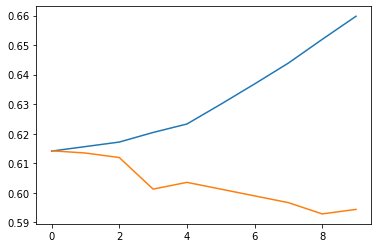

In [33]:
plt.plot(train_scores)
plt.plot(test_scores)
print(train_scores)
print(test_scores)

In [34]:
print(DecisionTreeClassifier(max_depth=3).fit(X_train,y_train).predict(X_test))
a = baseline_logit.predict(X_test)
np.mean(a)

1 - np.mean(tweets_to_split.stock_up)

[0 0 0 ... 0 0 0]


0.6141262803852622

---

In [84]:
tweets_to_split = tweets_stock_viable.drop(columns=['stock_dif','text', 'is_retweet', 'created_at'])

X_train, X_test, y_train, y_test = train_test_split(tweets_to_split.loc[:, tweets_to_split.columns != 'stock_up'], 
                                                         tweets_to_split.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = tweets_to_split.stock_up)

# START

In [61]:
tweets_stock_viable = pd.read_csv('data/tweets_stock_viable')

In [62]:
# https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = re.sub(r'http\S+', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [31]:
from string import punctuation

remove_terms = punctuation + '0123456789'

tweets = [[word.lower() for word in sent.split() if word not in remove_terms] for sent in tweets_stock_viable['text']]
tweets = [' '.join(tok_sent) for tok_sent in tweets]
tweets = filter(None, normalize_corpus(tweets))
tweets = [tok_sent for tok_sent in tweets if len(tok_sent.split()) > 2]

tweets

['debates especially second third plus speeches intensity large rallies plus great supporters gave us win',
 'election based total popular vote would campaigned ny florida california even bigger easily',
 'electoral college actually genius brings states including smaller ones play campaigning much different',
 'organized process taking place decide cabinet many positions one knows finalists',
 'trying get top level security clearance children typically false news story',
 'failing nytimes story totally wrong transition going smoothly also spoken many foreign leaders',
 'recieved taken calls many foreign leaders despite failing nytimes said russia uk china saudi arabia japan',
 'australia new zealand always available nytimes upset looked like fools coverage',
 'transition team working long hours fantastic job seeing many great candidates today maga',
 'got call friend bill ford chairman ford advised keeping lincoln plant kentucky mexico',
 'worked hard bill ford keep lincoln plant kentu

In [63]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in tweets]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['china', 'tariff', 'democrat', 'farmer', 'trade', 'war', 'xi','president']}
similar_words

{'china': ['product', 'tariffs', 'agricultural', 'chinas', 'buying'],
 'tariff': ['tariffs', 'davidson', 'offset', 'struggled', 'euro'],
 'democrat': ['party', 'wrecking', 'disgusting', 'bone', 'embrace'],
 'farmer': ['tune', 'starbucks', 'paid', 'rent', 'payoff'],
 'trade': ['fair', 'barriers', 'eu', 'tariffs', 'wto'],
 'war': ['peace', 'vietnam', 'resting', 'pearl', 'harbor'],
 'xi': ['jinping', 'barriersalso', 'peng', 'liyuan', 'madame'],
 'president': ['pro', 'whistle', 'donald', 'quid', 'none']}

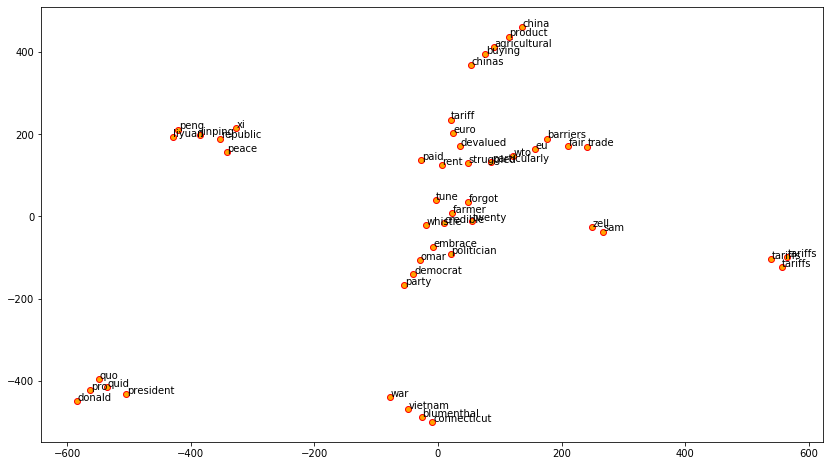

In [34]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [64]:
def add_similarity(word):
    succ = []
    for i in range(len(tweets_stock_viable)):
        similarities = []
        phrase = tweets_stock_viable['text'][i].lower()
        phrase = re.sub(r'[^a-zA-Z\s]', '', phrase, re.I|re.A)
        phrase = re.sub(r'http\S+', '', phrase)
        for w in phrase:
            if w in w2v_model.wv.vocab:
                similarities.append(w2v_model.wv.n_similarity([word], [w]))
        if similarities == []:
            succ.append(0)
        else:
            succ.append(max(similarities) + np.mean(similarities))
    tweets_stock_viable['{}_similarity'.format(word)] = succ
        

# Big problem here. Similarities with this self-made corpus seem to be always the same for 25/50/75 quantiles if you check the tweets_stock_viable.describe() output

# I don't know why this happens? I added the mean of the similarities of each word in each tweet to the similarity value appended to the df to give more variability but this underlying problem is still there. Also it doesn't improve our predictions whatsoever basically, even using RF.

In [65]:
words = ['china', 'tariff', 'trade', 'war', 'xi', 'intellectual', 'property', 'farm', 'soy', 'fentanyl', 'fed']
volfefe_vocab = ['china', 'xi', 'intellectual', 'soy', 'fentanyl', 'billion',  'products', 'fed',  'democrats',  'great',  'dollars',  'tariff',  'country',  'mueller',  'border', 'president', 'congressman', 'people', 'korea', 'years', 'farmers', 'going', 'trade', 'never']
for word in volfefe_vocab:
    add_similarity(word)

In [66]:
checkpoint = tweets_stock_viable

tweets_stock_viable.columns
tweets_stock_viable = tweets_stock_viable.drop(columns=['china', 'tariff', 'farmer', 'trade', 'war'], errors='ignore')
tweets_stock_viable.columns
tweets_stock_viable.created_at = pd.to_datetime(tweets_stock_viable.created_at)
tweets_stock_viable['hour'] = tweets_stock_viable.created_at.dt.hour + (tweets_stock_viable.created_at.dt.minute / 60)

In [68]:
tweets_to_split = tweets_stock_viable.drop(columns=['stock_dif','text', 'is_retweet', 'created_at'])

X_train, X_test, y_train, y_test = train_test_split(tweets_to_split.loc[:, tweets_to_split.columns != 'stock_up'], 
                                                         tweets_to_split.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = tweets_to_split.stock_up)

In [69]:
X_train

,retweet_count,favorite_count,polarity,subjectivity,test,china_similarity,xi_similarity,intellectual_similarity,soy_similarity,fentanyl_similarity,...,president_similarity,congressman_similarity,people_similarity,korea_similarity,years_similarity,farmers_similarity,going_similarity,trade_similarity,never_similarity,hour
920,14202.0,63653.0,0.866667,1.000000,0.800000,0.344453,0.560077,0.584744,0.238456,0.221745,...,0.166270,0.434849,0.183574,0.529250,0.218234,0.484276,0.143451,0.323357,0.122839,15.800000
268,34238.0,250940.0,0.800000,0.800000,0.800000,0.326598,0.570919,0.602918,0.238085,0.214465,...,0.419085,0.412784,0.205755,0.517604,0.230052,0.480158,0.142630,0.347649,0.128091,3.750000
4316,30708.0,107254.0,-0.146496,0.552652,-0.130871,0.344464,0.578514,0.590016,0.250093,0.229518,...,0.170795,0.408531,0.188798,0.530999,0.223510,0.495814,0.144201,0.342049,0.125887,13.616667
6332,2556.0,9218.0,0.750000,1.000000,0.600000,0.242744,0.398715,0.294751,0.300257,0.188153,...,0.440419,0.408728,0.164141,0.618459,0.183533,0.373813,0.117789,0.218525,0.138188,2.950000
3559,16456.0,73335.0,0.458667,0.566000,0.448667,0.355617,0.597764,0.615721,0.276366,0.252326,...,0.179310,0.386983,0.176356,0.570310,0.224351,0.493595,0.136036,0.337536,0.123927,12.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,13074.0,54987.0,0.495833,0.597222,0.477778,0.312101,0.555875,0.590613,0.238053,0.194375,...,0.103346,0.431532,0.188541,0.532746,0.221314,0.475930,0.137241,0.324980,0.119220,19.750000
682,54056.0,154284.0,0.000000,0.100000,0.000000,0.341006,0.551503,0.611215,0.218024,0.196358,...,0.078694,0.460911,0.167284,0.498137,0.234286,0.514381,0.155215,0.328929,0.107175,19.933333
3548,12797.0,52172.0,0.568182,0.602273,0.468182,0.317220,0.595734,0.612363,0.261877,0.226245,...,0.424249,0.395727,0.182971,0.555591,0.213801,0.480386,0.120563,0.330927,0.111747,22.716667
693,12454.0,56016.0,0.000000,1.000000,0.000000,0.385252,0.561002,0.631808,0.248063,0.243405,...,0.155778,0.405842,0.197107,0.511867,0.254270,0.512403,0.167951,0.367364,0.124999,20.250000


In [71]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(max_depth = 10, n_estimators=55, max_features='sqrt').fit(X_train, y_train)
random_forest_train_score = accuracy_score(RFclassifier.predict(X_train), y_train)
random_forest_test_score = accuracy_score(RFclassifier.predict(X_test), y_test)
print('Random Forest Accuracy on Training Set:', random_forest_train_score)
print('Random Forest Accuracy on Test Set:', random_forest_test_score)

Random Forest Accuracy on Training Set: 0.7146406727828746
Random Forest Accuracy on Test Set: 0.6111535523300229


# More changes to maybe have mutlinomial regression? 

In [76]:
checkpoint.describe()

,retweet_count,favorite_count,polarity,subjectivity,test,china,stock_dif,stock_up,tariff,farmer,...,border_similarity,president_similarity,congressman_similarity,people_similarity,korea_similarity,years_similarity,farmers_similarity,going_similarity,trade_similarity,never_similarity
count,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,...,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000
mean,19829.420425,84601.228864,0.154468,0.465600,0.141125,0.036080,0.001376,0.385874,0.017887,0.012383,...,0.099877,0.225433,0.401674,0.167022,0.520993,0.217218,0.474408,0.134390,0.322385,0.118670
std,10411.698740,39886.074368,0.339123,0.275408,0.305991,0.186504,0.973207,0.486838,0.132552,0.110598,...,0.033116,0.139480,0.076211,0.064976,0.097413,0.051667,0.084430,0.037036,0.064362,0.029889
min,2.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-11.750000,0.000000,0.000000,0.000000,...,-0.159649,-0.212905,-0.548030,-0.331614,-0.622468,-0.244053,-0.103424,-0.552306,-0.275662,-0.405913
25%,13410.000000,59522.000000,0.000000,0.300000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,...,0.091776,0.151659,0.396664,0.174307,0.520327,0.216749,0.474520,0.128827,0.320249,0.114084
50%,18173.000000,78736.000000,0.087500,0.500000,0.086667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102077,0.173803,0.413960,0.183548,0.537266,0.227146,0.490250,0.140114,0.335148,0.123118
75%,24056.000000,102505.000000,0.345833,0.651786,0.325000,0.000000,0.250000,1.000000,0.000000,0.000000,...,0.113617,0.412700,0.430577,0.192021,0.554244,0.236802,0.503631,0.150408,0.347928,0.131210
max,131283.000000,574621.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,...,0.272206,0.569252,0.662526,0.506153,0.720685,0.374901,0.650367,0.261948,0.519230,0.209210


In [95]:
tweets_multiclass = checkpoint
down = np.where(tweets_multiclass.stock_dif < -0.25, -1, 0)
up = np.where(tweets_multiclass.stock_dif > 0.25, 1, 0)
tweets_multiclass['stock_movement'] = down + up

tweets_multiclass.describe()

,retweet_count,favorite_count,polarity,subjectivity,test,china,stock_dif,stock_up,tariff,farmer,...,president_similarity,congressman_similarity,people_similarity,korea_similarity,years_similarity,farmers_similarity,going_similarity,trade_similarity,never_similarity,stock_movement
count,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,...,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000
mean,19829.420425,84601.228864,0.154468,0.465600,0.141125,0.036080,0.001376,0.385874,0.017887,0.012383,...,0.225433,0.401674,0.167022,0.520993,0.217218,0.474408,0.134390,0.322385,0.118670,-0.004739
std,10411.698740,39886.074368,0.339123,0.275408,0.305991,0.186504,0.973207,0.486838,0.132552,0.110598,...,0.139480,0.076211,0.064976,0.097413,0.051667,0.084430,0.037036,0.064362,0.029889,0.663008
min,2.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-11.750000,0.000000,0.000000,0.000000,...,-0.212905,-0.548030,-0.331614,-0.622468,-0.244053,-0.103424,-0.552306,-0.275662,-0.405913,-1.000000
25%,13410.000000,59522.000000,0.000000,0.300000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,...,0.151659,0.396664,0.174307,0.520327,0.216749,0.474520,0.128827,0.320249,0.114084,0.000000
50%,18173.000000,78736.000000,0.087500,0.500000,0.086667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.173803,0.413960,0.183548,0.537266,0.227146,0.490250,0.140114,0.335148,0.123118,0.000000
75%,24056.000000,102505.000000,0.345833,0.651786,0.325000,0.000000,0.250000,1.000000,0.000000,0.000000,...,0.412700,0.430577,0.192021,0.554244,0.236802,0.503631,0.150408,0.347928,0.131210,0.000000
max,131283.000000,574621.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,...,0.569252,0.662526,0.506153,0.720685,0.374901,0.650367,0.261948,0.519230,0.209210,1.000000


In [99]:
tweets_multiclass.columns
multiclass_df = tweets_multiclass.drop(columns=['china', 'tariff', 'farmer', 'trade', 'war','text', 'stock_dif', 'stock_up', 'is_retweet', 'created_at'], errors='ignore')
multiclass_df.columns

Index(['retweet_count', 'favorite_count', 'polarity', 'subjectivity', 'test',
       'china_similarity', 'xi_similarity', 'intellectual_similarity',
       'soy_similarity', 'fentanyl_similarity', 'billion_similarity',
       'products_similarity', 'fed_similarity', 'democrats_similarity',
       'great_similarity', 'dollars_similarity', 'tariff_similarity',
       'country_similarity', 'mueller_similarity', 'border_similarity',
       'president_similarity', 'congressman_similarity', 'people_similarity',
       'korea_similarity', 'years_similarity', 'farmers_similarity',
       'going_similarity', 'trade_similarity', 'never_similarity',
       'stock_movement'],
      dtype='object')

In [104]:
X_train, X_test, y_train, y_test = train_test_split(multiclass_df.loc[:, multiclass_df.columns != 'stock_movement'], 
                                                         multiclass_df.stock_movement, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = multiclass_df.stock_movement)

from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(max_depth = 7, n_estimators=250, max_features='sqrt').fit(X_train, y_train)
random_forest_train_score = accuracy_score(RFclassifier.predict(X_train), y_train)
random_forest_test_score = accuracy_score(RFclassifier.predict(X_test), y_test)
print('Random Forest Accuracy on Training Set:', random_forest_train_score)
print('Random Forest Accuracy on Test Set:', random_forest_test_score)

Random Forest Accuracy on Training Set: 0.5676605504587156
Random Forest Accuracy on Test Set: 0.5630252100840336


# appendix 
---

In [ ]:
# playpen
nlp = sp.load('en_core_web_md') 



doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)
    
    
    
token1, token2 = doc[0], doc[1] 
print("Similarity:", token1.similarity(token2))


c = nlp('red')
t = nlp('blue')
c.similarity(t)



w1 = wordnet.synset('corn.n.01') # v here denotes the tag verb 
w2 = wordnet.synset('farmer.n.01') 
print(w1.wup_similarity(w2)) 




doc = nlp(tweets_stock_viable['text'].values[1].lower())

print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)
    
c = nlp('china')
for token in doc:
    print(c.similarity(token))
    
    
    
    
# doc2vec
data = list(tweets_stock_viable['text'])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")



for i in range(20):
    tweets_stock_viable['vec{}'.format(i)] = [0] * 6541

for i in range(6541):
    if i % 100 == 0:
        print(i)
    for j in range(20):
        tweets_stock_viable['vec{}'.format(j)][i] = model.docvecs[i][j]
    
tweets_stock_viable

###
tweets_stock_viable = tweets_stock_viable.drop(columns=['vector'])

cols = ['vec{}'.format(i) for i in range(20)]
vectorized = pd.DataFrame(model.docvecs.doctag_syn0, columns=cols)
vectorized

new_tweets = pd.concat([tweets_stock_viable, vectorized], axis=1)

new_tweets

###

reference = [['china'], ['tariff']]
candidate = ['china', 'trade', 'war']
score = sentence_bleu(reference, candidate)
print(score)

In [ ]:
# manual Skip Gram Model
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(tweets)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in tweets]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])


###
from tensorflow.keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

###
# https://stackoverflow.com/questions/52744467/keras-translation-from-sequential-to-functional-api
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

word_input = Input(shape=(1,))
word_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(word_input)
word_reshape = layers.Reshape((embed_size,))(word_x)

word_model = Model(word_input, word_reshape)    

context_input = Input(shape=(1,))
context_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(context_input)
context_reshape = layers.Reshape((embed_size,))(context_x)

context_model = Model(context_input, context_reshape)

dot_output = layers.dot([word_reshape, context_reshape], axes=1, normalize=False)

model_output = layers.Dense(1, kernel_initializer='glorot_uniform',
                            activation='sigmoid')(dot_output)

model = Model([word_input, context_input], model_output)

model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

# visualize model structure
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train Model
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)